In [9]:
# Import data
import pandas as pd
from sklearn.metrics import accuracy_score,auc
path='/home/stephenvu/Downloads/712_code/'
from sklearn.svm import SVC
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D
from keras.layers.merge import concatenate
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import scipy.stats as stats

In [2]:

df_1= pd.read_excel(path+"/maindata.xlsx",sheet_name=0) #read mesc
df_2 = pd.read_excel(path+"/maindata.xlsx",sheet_name=1) #read hl60
df_3 = pd.read_excel(path+"/maindata.xlsx",sheet_name=2) #read hela_hart
df_4 = pd.read_excel(path+"/maindata.xlsx",sheet_name=3) #read HEK293T
df_5 = pd.read_excel(path+"/maindata.xlsx",sheet_name=4) #read HCT116
# df=pd.concat([df_1,df_2,df_3,df_4,df_5]).reset_index().drop(columns=['index'])
# # df=pd.concat([df_1,df_2]).reset_index().drop(columns=['index'])
# df=df.drop_duplicates(subset=['seq','label'])


# First method: SGRNA-Design from Doench,2014

In [3]:
# This is a 13 line python function to calculate the sgRNA on-target efficacy score from the article
# "Rational design of highly active sgRNAs for CRISPR-Cas9–mediated gene inactivation"
# by J Doench et al. 2014
# The authors' web tool is available at http://www.broadinstitute.org/rnai/public/analysis-tools/sgrna-design
# Thanks to Cameron Mac Pherson at Pasteur Paris for fixing my original version. Maximilian Haeussler 2014
 
import math
 
params = [
# pasted/typed table from PDF and converted to zero-based positions
(1,'G',-0.2753771),(2,'A',-0.3238875),(2,'C',0.17212887),(3,'C',-0.1006662),
(4,'C',-0.2018029),(4,'G',0.24595663),(5,'A',0.03644004),(5,'C',0.09837684),
(6,'C',-0.7411813),(6,'G',-0.3932644),(11,'A',-0.466099),(14,'A',0.08537695),
(14,'C',-0.013814),(15,'A',0.27262051),(15,'C',-0.1190226),(15,'T',-0.2859442),
(16,'A',0.09745459),(16,'G',-0.1755462),(17,'C',-0.3457955),(17,'G',-0.6780964),
(18,'A',0.22508903),(18,'C',-0.5077941),(19,'G',-0.4173736),(19,'T',-0.054307),
(20,'G',0.37989937),(20,'T',-0.0907126),(21,'C',0.05782332),(21,'T',-0.5305673),
(22,'T',-0.8770074),(23,'C',-0.8762358),(23,'G',0.27891626),(23,'T',-0.4031022),
(24,'A',-0.0773007),(24,'C',0.28793562),(24,'T',-0.2216372),(27,'G',-0.6890167),
(27,'T',0.11787758),(28,'C',-0.1604453),(29,'G',0.38634258),(1,'GT',-0.6257787),
(4,'GC',0.30004332),(5,'AA',-0.8348362),(5,'TA',0.76062777),(6,'GG',-0.4908167),
(11,'GG',-1.5169074),(11,'TA',0.7092612),(11,'TC',0.49629861),(11,'TT',-0.5868739),
(12,'GG',-0.3345637),(13,'GA',0.76384993),(13,'GC',-0.5370252),(16,'TG',-0.7981461),
(18,'GG',-0.6668087),(18,'TC',0.35318325),(19,'CC',0.74807209),(19,'TG',-0.3672668),
(20,'AC',0.56820913),(20,'CG',0.32907207),(20,'GA',-0.8364568),(20,'GG',-0.7822076),
(21,'TC',-1.029693),(22,'CG',0.85619782),(22,'CT',-0.4632077),(23,'AA',-0.5794924),
(23,'AG',0.64907554),(24,'AG',-0.0773007),(24,'CG',0.28793562),(24,'TG',-0.2216372),
(26,'GT',0.11787758),(28,'GG',-0.69774)]
 
intercept =  0.59763615
gcHigh    = -0.1665878
gcLow     = -0.2026259
 
def calcDoenchScore(seq):
    score = intercept
 
    guideSeq = seq[4:24]
    gcCount = guideSeq.count("G") + guideSeq.count("C")
    if gcCount <= 10:
        gcWeight = gcLow
    if gcCount > 10:
        gcWeight = gcHigh
    score += abs(10-gcCount)*gcWeight
 
    for pos, modelSeq, weight in params:
        subSeq = seq[pos:pos+len(modelSeq)]
        if subSeq==modelSeq:
            score += weight
    return 1.0/(1.0+math.exp(-score))
 
def validate_data1(df): 
    result = []
    for i in df['seq']: 
        score = calcDoenchScore(i)
        if score>0.5: 
            result.append(1)
        else: 
            result.append(0)
    df['doench_2014'] = result 
    return df 

In [5]:
df_1=validate_data1(df_1) 
df_2=validate_data1(df_2) 
df_3=validate_data1(df_3) 
df_4=validate_data1(df_4) 
df_5=validate_data1(df_5) 
con1 = pd.concat([df_1,df_2,df_3,df_4,df_5])
con1

,seq,data,label,doench_2014
0,TTGGTGATGCTCACGAACGATGG,mesc,1,1
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1,0
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1,0
3,AACCTGGACCCCGCTAACGACGG,mesc,1,1
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1,0
...,...,...,...,...
4234,CACACAGTGTCCAGATACGAGGG,hct116,1,0
4235,CCAAATCCCAAACCTTACCCTGG,hct116,1,0
4236,CATCGATGTGTGCTGTGGCCAGG,hct116,0,0
4237,GCTCTTGGAGATGTACAGGAAGG,hct116,1,0


In [11]:
print(1-accuracy_score(df_1['label'],df_1['doench_2014']))
print(1-accuracy_score(df_2['label'],df_2['doench_2014']))
print(1-accuracy_score(df_3['label'],df_3['doench_2014']))
print(1-accuracy_score(df_4['label'],df_4['doench_2014']))
print(1-accuracy_score(df_5['label'],df_5['doench_2014']))
from sklearn.metrics import roc_curve,roc_auc_score


0.7005870841487281
0.6748554913294798
0.6086902851499815
0.5636519502786113
0.6117008728473696


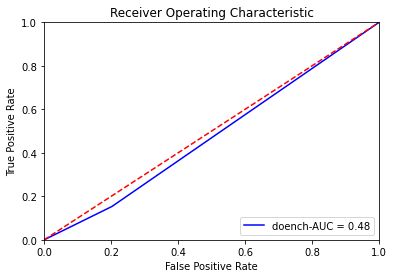

# 2. CRISPR-SCAN

In [14]:
paramsCRISPRscan = [
# converted excel table of logistic regression weights with 1-based positions
('AA',18,-0.097377097),
('TT',18,-0.094424075),('TT',13,-0.08618771),('CT',26,-0.084264893),('GC',25,-0.073453609),
('T',21,-0.068730497),('TG',23,-0.066388075),('AG',23,-0.054338456),('G',30,-0.046315914),
('A',4,-0.042153521),('AG',34,-0.041935908),('GA',34,-0.037797707),('A',18,-0.033820432),
('C',25,-0.031648353),('C',31,-0.030715556),('G',1,-0.029693709),('C',16,-0.021638609),
('A',14,-0.018487229),('A',11,-0.018287292),('T',34,-0.017647692),('AA',10,-0.016905415),
('A',19,-0.015576499),('G',34,-0.014167123),('C',30,-0.013182733),('GA',31,-0.01227989),
('T',24,-0.011996172),('A',15,-0.010595296),('G',4,-0.005448869),('GG',9,-0.00157799),
('T',23,-0.001422243),('C',15,-0.000477727),('C',26,-0.000368973),('T',27,-0.000280845),
('A',31,0.00158975),('GT',18,0.002391744),('C',9,0.002449224),('GA',20,0.009740799),
('A',25,0.010506405),('A',12,0.011633235),('A',32,0.012435231),('T',22,0.013224035),
('C',20,0.015089514),('G',17,0.01549378),('G',18,0.016457816),('T',30,0.017263162),
('A',13,0.017628924),('G',19,0.017916844),('A',27,0.019126815),('G',11,0.020929039),
('TG',3,0.022949996),('GC',3,0.024681785),('G',14,0.025116714),('GG',10,0.026802158),
('G',12,0.027591138),('G',32,0.03071249),('A',22,0.031930909),('G',20,0.033957008),
('C',21,0.034262921),('TT',17,0.03492881),('T',13,0.035445171),('G',26,0.036146649),
('A',24,0.037466478),('C',22,0.03763162),('G',16,0.037970942),('GG',12,0.041883009),
('TG',18,0.045908991),('TG',31,0.048136812),('A',35,0.048596259),('G',15,0.051129717),
('C',24,0.052972314),('TG',15,0.053372822),('GT',11,0.053678436),('GC',9,0.054171402),
('CA',30,0.057759851),('GT',24,0.060952114),('G',13,0.061360905),('CA',24,0.06221937),
('AG',10,0.063717093),('G',10,0.067739182),('C',13,0.069495944),('GT',31,0.07342535),
('GG',13,0.074355848),('C',27,0.079933922),('G',27,0.085151052),('CC',21,0.088919601),
('CC',23,0.095072286),('G',22,0.10114438),('G',24,0.105488325),('GT',23,0.106718563),
('GG',25,0.111559441),('G',9,0.114600681)]

def calcCrisprScanScores(seqs):
    """ input is a 35bp long sequence: 6bp 5', 20bp guide, 3 bp PAM and 6bp 3'
    >>> calcCrisprScanScores(["TCCTCTGGTGGCGCTGCTGGATGGACGGGACTGTA"])
    [77]
    >>> calcCrisprScanScores(["TCCTCTNGTGGCGCTGCTGGATGGACGGGACTGTA"])
    [77]
    """
    scores = []
    for seq in seqs:
        #assert(len(seq)==35)
        intercept = 0.183930943629
        score = intercept
        for modelSeq, pos, weight in paramsCRISPRscan:
            subSeq = seq[pos-1:pos+len(modelSeq)-1]
            if subSeq==modelSeq:
                score += weight
        scores.append(score)
    return scores
def validate_data2(df): 
    result = []
    scores = calcCrisprScanScores(df['seq'])
    for score in scores:
        if score>0.5: 
            result.append(1)
        else: 
            result.append(0)
    df['crisprscan'] = result 
    return df 

In [15]:
df_1=validate_data2(df_1) 
df_2=validate_data2(df_2) 
df_3=validate_data2(df_3) 
df_4=validate_data2(df_4) 
df_5=validate_data2(df_5) 
print(1-accuracy_score(df_1['label'],df_1['crisprscan']))
print(1-accuracy_score(df_2['label'],df_2['crisprscan']))
print(1-accuracy_score(df_3['label'],df_3['crisprscan']))
print(1-accuracy_score(df_4['label'],df_4['crisprscan']))
print(1-accuracy_score(df_5['label'],df_5['crisprscan']))


0.6311154598825832
0.569364161849711
0.5756079496358475
0.5383626232318903
0.5902335456475584


# 3. SSC SCORE

df_1['seq'][0]

In [16]:
import re
seq=df_1['seq'][0][:-3]

In [17]:
def calcSscScores(seqs):
    """ calc the SSC scores from the paper Xu Xiao Chen Li Meyer Brown Lui Gen Res 2015 
    Input is a 30mer, 20bp for the guide, 3bp PAM, 7bp 3' flanking
    intercept=0
    """
    score = []
    ssc=pd.read_csv('/home/stephenvu/Downloads/crisporWebsite/bin/src/SSC0.1/matrix/human_CRISPRi_20bp.matrix',sep="\t").reset_index()
    for s in seqs: 
        seq = s[:-3]
        num=0
        base = ['A','T','G','C']
        for i in base:
            ind=find(seq,i)
            for j in ind:
                num+=ssc.loc[j,i]
        score.append(num)
    return score
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]
def validate_data3(df): 
    result = []
    scores = calcSscScores(df['seq'])
    for score in scores:
        if score>0.5: 
            result.append(1)
        else: 
            result.append(0)
    df['SSC'] = result 
    return df 
    

In [19]:
df_1=validate_data3(df_1) 
df_2=validate_data3(df_2) 
df_3=validate_data3(df_3) 
df_4=validate_data3(df_4) 
df_5=validate_data3(df_5) 
print(1-accuracy_score(df_1['label'],df_1['SSC']))
print(1-accuracy_score(df_2['label'],df_2['SSC']))
print(1-accuracy_score(df_3['label'],df_3['SSC']))
print(1-accuracy_score(df_4['label'],df_4['SSC']))
print(1-accuracy_score(df_5['label'],df_5['SSC']))


0.7798434442270059
0.710019267822736
0.6246142451549191
0.5889412773253322
0.6411889596602973


In [26]:
con1 = pd.concat([df_1,df_2,df_3,df_4,df_5]).reset_index().drop(columns='index')
con1

,seq,data,label,doench_2014,crisprscan,SSC
0,TTGGTGATGCTCACGAACGATGG,mesc,1,1,0,0
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1,0,0,0
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1,0,1,0
3,AACCTGGACCCCGCTAACGACGG,mesc,1,1,0,0
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1,0,1,0
...,...,...,...,...,...,...
17766,CACACAGTGTCCAGATACGAGGG,hct116,1,0,0,0
17767,CCAAATCCCAAACCTTACCCTGG,hct116,1,0,0,0
17768,CATCGATGTGTGCTGTGGCCAGG,hct116,0,0,1,0
17769,GCTCTTGGAGATGTACAGGAAGG,hct116,1,0,0,0


# Deep-SVR 

In [11]:
# -*- coding:utf-8 -*-

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import tensorflow as tf
# import keras.backend.tensorflow_backend as KTF
#
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# session = tf.Session(config=config)
#
# KTF.set_session(session)

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D
from keras.layers.merge import concatenate
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import scipy.stats as stats


def grna_preprocess(lines):
    length = 23
    data_n = len(lines)
    seq = np.zeros((data_n, length, 4), dtype=int)
    for l in range(data_n):
        data = lines[l]
        seq_temp = data
        for i in range(length):
            if seq_temp[i] in "Aa":
                seq[l, i, 0] = 1
            elif seq_temp[i] in "Cc":
                seq[l, i, 1] = 1
            elif seq_temp[i] in "Gg":
                seq[l, i, 2] = 1
            elif seq_temp[i] in "Tt":
                seq[l, i, 3] = 1
    return seq


def epi_preprocess(lines):
    length = 23
    data_n = len(lines)
    epi = np.zeros((data_n, length), dtype=int)
    for l in range(data_n):
        data = lines[l]
        epi_temp = data
        for i in range(length):
            if epi_temp[i] in "A":
                epi[l, i] = 1
            elif epi_temp[i] in "N":
                epi[l, i] = 0
    return epi


def preprocess(file_path, usecols):
    data = pd.read_csv(file_path, usecols=usecols)
    data = np.array(data)
    ctcf, dnase, h3k4me3, rrbs = epi_preprocess(data[:, 0]), epi_preprocess(data[:, 1]), epi_preprocess(data[:, 2]), epi_preprocess(data[:, 3])
    epi = []
    for i in range(len(data)):
        ctcf_t, dnase_t, h3k4me3_t, rrbs_t = pd.DataFrame(ctcf[i]), pd.DataFrame(dnase[i]), pd.DataFrame(h3k4me3[i]), pd.DataFrame(rrbs[i])
        epi_t = pd.concat([ctcf_t, dnase_t, h3k4me3_t, rrbs_t], axis=1)
        epi_t = np.array(epi_t)
        epi.append(epi_t)
    epi = np.array(epi)
    return epi


def load_data(train_file, test_file):
    train_data = pd.read_csv(train_file, usecols=[4, 9])
    train_data = np.array(train_data)
    train_seq, train_y = train_data[:, 0], train_data[:, 1]
    train_seq = grna_preprocess(train_seq)
    train_epi = preprocess(train_file, [5, 6, 7, 8])
    train_y = train_y.reshape(len(train_y), -1)

    test_data = pd.read_csv(test_file, usecols=[4, 9])
    test_data = np.array(test_data)
    test_seq, test_y = test_data[:, 0], test_data[:, 1]
    test_seq = grna_preprocess(test_seq)
    test_epi = preprocess(test_file, [5, 6, 7, 8])
    test_y = test_y.reshape(len(test_y), -1)
    return train_seq, test_seq, train_epi, test_epi, train_y, test_y


# Build model
def build_model():
    dropout = 0.3
    seq_input = Input(shape=(23, 4))
    seq_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_1')(seq_input)
    seq_act1 = Activation('relu', name='seq_activation1')(seq_conv1)
    seq_pool1 = AveragePooling1D(2, name='seq_pooling_1')(seq_act1)
    seq_drop1 = Dropout(dropout)(seq_pool1)

    seq_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_2')(seq_drop1)
    seq_act2 = Activation('relu', name='seq_activation_2')(seq_conv2)
    seq_pool2 = AveragePooling1D(2, name='seq_pooling_2')(seq_act2)
    seq_drop2 = Dropout(dropout)(seq_pool2)
    seq_flat = Flatten()(seq_drop2)

    seq_dense1 = Dense(256, activation='relu', name='seq_dense_1')(seq_flat)
    seq_drop3 = Dropout(dropout)(seq_dense1)
    seq_dense2 = Dense(128, activation='relu', name='seq_dense_2')(seq_drop3)
    seq_drop4 = Dropout(dropout)(seq_dense2)
    seq_dense3 = Dense(64, activation='relu', name='seq_dense_3')(seq_drop4)
    seq_drop5 = Dropout(dropout)(seq_dense3)
    seq_out = Dense(40, activation='relu', name='seq_dense_4')(seq_drop5)

    epi_input = Input(shape=(23, 4))
    epi_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_1')(epi_input)
    epi_act1 = Activation('relu', name='epi_activation_1')(epi_conv1)
    epi_pool1 = AveragePooling1D(2, name='epi_pooling_1')(epi_act1)
    epi_drop1 = Dropout(dropout)(epi_pool1)

    epi_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_2')(epi_drop1)
    epi_act2 = Activation('relu', name='epi_activation_2')(epi_conv2)
    epi_pool2 = AveragePooling1D(2, name='epi_pooling_2')(epi_act2)
    epi_drop2 = Dropout(dropout)(epi_pool2)
    epi_flat = Flatten()(epi_drop2)

    epi_dense1 = Dense(256, activation='relu', name='epi_dense_1')(epi_flat)
    epi_drop3 = Dropout(dropout)(epi_dense1)
    epi_dense2 = Dense(128, activation='relu', name='epi_dense_2')(epi_drop3)
    epi_drop4 = Dropout(dropout)(epi_dense2)
    epi_dense3 = Dense(64, activation='relu', name='epi_dense_3')(epi_drop4)
    epi_drop5 = Dropout(dropout)(epi_dense3)
    epi_out = Dense(40, activation='relu', name='epi_dense_4')(epi_drop5)

    merged = concatenate([seq_out, epi_out], axis=-1)

    pretrain_model = Model(inputs=[seq_input, epi_input], outputs=[merged])

    # Load weights for the model
    pretrain_model.load_weights("weights.h5", by_name=True)

    prediction = Dense(1, activation='linear', name='prediction')(merged)
    model = Model([seq_input, epi_input], prediction)
    return merged, model


# if __name__ == '__main__':

#     train_path = "/home/stephenvu/Downloads/CNN-SVR/data/training_example.csv"
#     test_path = "/home/stephenvu/Downloads/CNN-SVR/data/testing_example.csv"

#     # Load data
#     seq_train, seq_test, epi_train, epi_test, y_train, y_test = load_data(train_path, test_path)

#     merged, model = build_model()

#     new_model = Model(model.inputs, outputs=[merged])
#     x_train = new_model.predict([seq_train, epi_train])
#     x_test = new_model.predict([seq_test, epi_test])

#     x_train, x_test = np.array(x_train), np.array(x_test)

#     # Select important features from initial CNN features
#     selected_cnn_fea_cols = [17, 26, 9, 19, 30, 6, 12, 39, 36, 21, 22, 3, 25]
#     x_train = x_train[:, selected_cnn_fea_cols]
#     x_test = x_test[:, selected_cnn_fea_cols]

#     y_train = np.array(y_train).ravel()
#     y_test = np.array(y_test).ravel()

#     clf = SVC(kernel="rbf", gamma=0.12, C=1.7)

#     # Fit the SVR model according to the given training data
#     clf.fit(x_train, y_train)

#     # Perform regression on samples in x_test
#     y_pred = clf.predict(x_test)
#     print(y_pred)

#     # Calculate Spearman correlation coefficient
#     # Spearman_correlation, _ = stats.stats.spearmanr(y_test, y_pred)

#     # Print Spearman correlation result
#     # print("Spearman correlation=%.3f" % (Spearman_correlation))
































In [12]:
accuracy_score_SVR = 0.61516167
# Check process.ipynb for the code

In [13]:
df_1

,seq,data,label,doench_2014,crisprscan,SSC
0,TTGGTGATGCTCACGAACGATGG,mesc,1,1,0,0
1,AGTGCAGCTGGATGCGCCCGTGG,mesc,1,0,0,0
2,CTGCAATGACGAGGGTGCCCTGG,mesc,1,0,1,0
3,AACCTGGACCCCGCTAACGACGG,mesc,1,1,0,0
4,TTACGAGTGTGCGGTGGACGTGG,mesc,1,0,1,0
...,...,...,...,...,...,...
1017,GTAGTCTGCCTCGAAGCTCTCGG,mesc,1,0,0,0
1018,CAACATTTAAATATGATCCTGGG,mesc,0,0,0,0
1019,GTTTGAAGAGGTCGGTGCACGGG,mesc,1,0,1,0
1020,CGTTTGAAGAGGTCGGTGCACGG,mesc,1,0,1,0


In [25]:
SVR=[0.48148148148148145,
0.6270718232044199,
0.496986301369863,
0.5086805555555556,
0.47535596933187296,]
SSC=[0.7798434442270059,
0.710019267822736,
0.6246142451549191,
0.5889412773253322,
0.6411889596602973]
CRISPR_SCAN = [0.6311154598825832,
0.569364161849711,
0.5756079496358475,
0.5383626232318903,
0.5902335456475584]
doench = [0.7005870841487281,
0.6748554913294798,
0.6086902851499815,
0.5636519502786113,
0.6117008728473696]
deep_snmf=[0.61666667, 0.636188  , 0.66726027, 0.67083333, 0.67464403]

In [31]:
result=pd.DataFrame([doench,CRISPR_SCAN,SSC,SVR,deep_snmf],columns=['mesc','hl61','hela','hek293t','hct116'],index=['doench','crispr_scan','ssc','svr','deep_snmf'])

In [27]:
result.to_excel('result_true.xlsx')

In [32]:
result.columns

Index(['mesc', 'hl61', 'hela', 'hek293t', 'hct116'], dtype='object')

In [33]:
result = result.reset_index()
result

,index,mesc,hl61,hela,hek293t,hct116
0,doench,0.700587,0.674855,0.608690,0.563652,0.611701
1,crispr_scan,0.631115,0.569364,0.575608,0.538363,0.590234
2,ssc,0.779843,0.710019,0.624614,0.588941,0.641189
3,svr,0.481481,0.627072,0.496986,0.508681,0.475356
4,deep_snmf,0.616667,0.636188,0.667260,0.670833,0.674644


In [36]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
  
# read dataset from csv and perform preprocessing
data = result
data.head()
  
# # remove goalkeepers data for performing fair comparison
# goalkeeper_index = data[data['Position'] == 'GK' ].index
# data.drop(index_names,inplace=True)
  
# remove columns which are not required for this visualisation purpose
plt_vars = ['mesc', 'hl61', 'hela', 'hek293t', 'hct116']
# data.drop(data_cols, axis =1, inplace=True)

# plot unfilled scatter plot
# plot star plot for comparison
fig = go.Figure()
  
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[0].values),
      theta=plt_vars,

      name=data.loc[0, 'index']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[1,plt_vars].values),
      theta=plt_vars,

      name=data.loc[1, 'index']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[2,plt_vars].values),
      theta=plt_vars,

      name=data.loc[2, 'index']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[3,plt_vars].values),
      theta=plt_vars,

      name=data.loc[3, 'index']
))
fig.add_trace(go.Scatterpolar(
      r=pd.Series(data.loc[4,plt_vars].values),
      theta=plt_vars,
    
      name=data.loc[4, 'index']
))

  
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
          )),

  template = 'plotly_dark',
  showlegend=True
)

fig.show()


In [47]:
import seaborn as sns
def plot_imbalance(df):
    count0=[]
    count1=[]
    for data in df: 
        count_class_1, count_class_0 = data.label.value_counts()
        count0.append(count_class_0)
        count1.append(count_class_1)
    result = pd.DataFrame([count0,count1],columns=['mesc','hl61','hela','hek293t','hct116'],index=['ineffective','effective'])
    result=result
    return result

In [54]:
result2=plot_imbalance([df_1,df_2,df_3,df_4,df_5,])
f = result2.T.reset_index()

In [55]:
import matplotlib.pyplot as plt 
# sns.set_theme('whitegrid')
tidy = f.melt(id_vars='index').rename(columns=str.title)


In [56]:
tidy

,Index,Variable,Value
0,mesc,ineffective,225
1,hl61,ineffective,602
2,hela,ineffective,3041
3,hek293t,ineffective,959
4,hct116,ineffective,1521
5,mesc,effective,797
6,hl61,effective,1474
7,hela,effective,5060
8,hek293t,effective,1374
9,hct116,effective,2718


Text(0.5, 1.0, 'Data Imbalance')

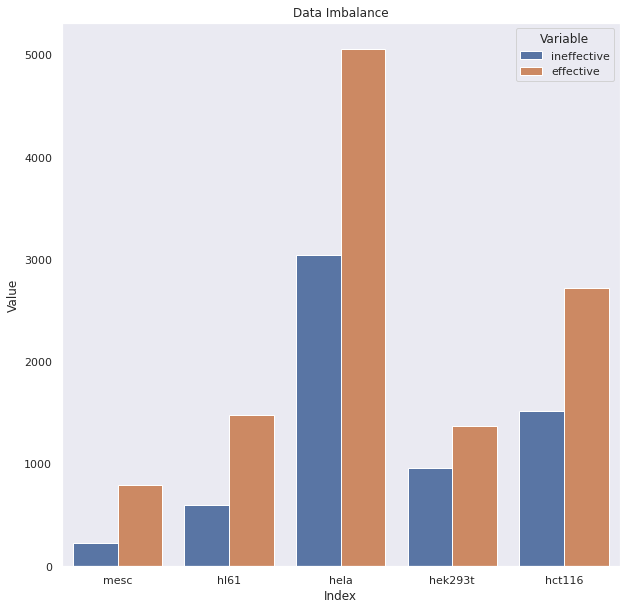

In [63]:
sns.set_theme(style='dark')
fig,ax1= plt.subplots(figsize=(10,10))
sns.barplot(x='Index',y='Value',hue='Variable',data=tidy,ax=ax1).set_title('Data Imbalance')

In [38]:
h2 = pd.read_hdf('H2.h5')
y_label=con1['label'].tail(3023)

In [41]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=2).fit(h2[:2500],y_label[:2500])


In [46]:
accuracy_score(y_label,y_deep)

0.45881574594773405

In [42]:
y_deep = clf.predict(h2,y_label)